# On normalizing flows


- density estimation (i.e., moon data) and sampling
- (variational) inference and reparameterization for MCMC (see orig flow paper)

- autoregressive flows (transformer and conditioner)
- coupling flows (realnvp)
- masked autoregressive flows
- ffored
- inverse autoregressive flows
-planar and radial
 => easy to compute jacobian! 

- cubic spline flows

- references:
    - the one blog
    - review from papa
    - orig papers
    - eric jang

In [1]:
import pymc4

## Normalizing flows

explain theory here. change of variables, etc.

explain that lower jacobian is good

explain how multiple jacobians compuite

explain how jacobian is computed

In [1]:
## Density estimation, a simple example using TFP (data real nvp data)


## Variational inference
## Density estimation

make more complex examples with TFP

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import numpy as np
n = 2000
x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)


In [ ]:
n = 1000

(-2.0, 2.0)

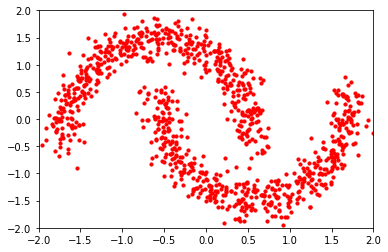

In [13]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.1)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)


xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [187]:
def create_masks(input_dim,
                 hidden_dims,
                 input_order='left-to-right',
                 hidden_order='left-to-right'):
  """Returns a list of binary mask matrices respecting autoregressive ordering.
  Args:
    input_dim: Number of inputs.
    hidden_dims: list with the number of hidden units per layer. It does not
      include the output layer; those number of units will always be set to
      input_dim downstream. Each hidden unit size must be at least the size of
      length (otherwise autoregressivity is not possible).
    input_order: Order of degrees to the input units: 'random', 'left-to-right',
      'right-to-left', or an array of an explicit order. For example,
      'left-to-right' builds an autoregressive model
      p(x) = p(x1) p(x2 | x1) ... p(xD | x<D).
    hidden_order: Order of degrees to the hidden units: 'random',
      'left-to-right'. If 'left-to-right', hidden units are allocated equally
      (up to a remainder term) to each degree.
  """
  degrees = create_degrees(input_dim, hidden_dims, input_order, hidden_order)
  masks = []
  # Create input-to-hidden and hidden-to-hidden masks.
  for input_degrees, output_degrees in zip(degrees[:-1], degrees[1:]):
    mask = tf.cast(input_degrees[:, np.newaxis] <= output_degrees, tf.float32)
    masks.append(mask)

  # Create hidden-to-output mask.
  mask = tf.cast(degrees[-1][:, np.newaxis] < degrees[0], tf.float32)
  masks.append(mask)
  return masks


In [228]:
create_masks(2, [3, 3])

[<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[1., 1., 1.],
        [0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32)>]

In [236]:
def make_degrees(p, hidden_dims):
    m = [tf.random.shuffle(tf.constant(range(1, p + 1)))]
    for dim in hidden_dims:                
        n_min = min(np.min(m[-1]), p - 1)
        degrees = np.random.randint(low=n_min, high=p, size=dim)
        degrees = tf.constant(degrees, dtype="int32")
        m.append(degrees)
    return m

In [239]:
degrees = make_degrees(3, [5, 5])
degrees

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 1, 2], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 2, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([2, 2, 2, 1, 1], dtype=int32)>]

In [225]:
def make_masks(degrees):
    masks = [None] * len(degrees)
    for i, (ind, outd) in enumerate(zip(degrees[:-1], degrees[1:])):
        masks[i] = tf.cast(outd[:, tf.newaxis] >= ind, dtype="int32")        
    masks[-1] = tf.cast(degrees[0][:, np.newaxis] > degrees[-1], dtype="int32")
    return masks

In [244]:
masks = make_masks(make_degrees(3, [4]))
masks

[<tf.Tensor: shape=(4, 3), dtype=int32, numpy=
 array([[1, 0, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(3, 4), dtype=int32, numpy=
 array([[0, 0, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 0, 1]], dtype=int32)>]

In [14]:
def make_layers(p, hidden_dims, activat):
    masks = make_masks(p, hidden_dims)
    

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
def made(input_d)

In [81]:
def make_maf(p):
    net_init, net_apply = stax.serial(
        Dense(512), Relu, Dense(512), Relu, Dense(D))
    in_shape = (-1, p // 2)
    out_shape, net_params = net_init(rng, in_shape)
    
    def shift_and_log_scale_fn(net_params, x1):
        s = net_apply(net_params, x1)
        return np.split(s, 2, axis=1)
    
    return net_params, shift_and_log_scale_fn

In [7]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

In [48]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="leaky_relu"):
        super(LeakyReLU, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):

        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_J_inv, axis=event_dims)

In [76]:
bi = tfb.Chain([tfb.Affine(shift=0, 
                           scale_identity_multiplier=1.),
           #
           tfb.Affine(scale_identity_multiplier=1.)])

In [77]:
bi.forward_log_det_jacobian(x, 1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [3]:
import jax.numpy as np
from jax import random

In [73]:
def sample_n01(N, D = 2):    
    return random.normal(rng, (N, D))

def log_prob_n01(x):
    return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

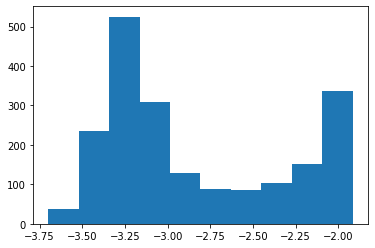

In [75]:
plt.hist(log_prob_n01(X));

In [1]:
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu

In [4]:
rng = random.PRNGKey(0)

/home/simon/miniconda3/envs/pymc/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [78]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
    d = x.shape[-1]//2
    x1, x2 = x[:, :d], x[:, d:]
    if flip:
        x2, x1 = x1, x2
    shift, log_scale = shift_and_log_scale_fn(net_params, x1)
    y2 = x2*np.exp(log_scale) + shift
    if flip:
        x1, y2 = y2, x1
    y = np.concatenate([x1, y2], axis=-1)
    return y

In [79]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
    d = y.shape[-1]//2
    y1, y2 = y[:, :d], y[:, d:]
    if flip:
        y1, y2 = y2, y1
    shift, log_scale = shift_and_log_scale_fn(net_params, y1)
    x2 = (y2-shift)*np.exp(-log_scale)
    if flip:
        y1, x2 = x2, y1
    x = np.concatenate([y1, x2], axis=-1)
    return x, log_scale

In [247]:
nvp = init_nvp()

NameError: name 'init_nvp' is not defined

In [91]:
nvp[1]

<function __main__.init_nvp.<locals>.shift_and_log_scale_fn(net_params, x1)>

In [92]:
def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
    x = base_sample_fn(N)
    return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
    x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
    ildj = -np.sum(log_scale, axis=-1)
    return base_log_prob_fn(x) + ildj

In [93]:
def init_nvp_chain(n=2):
    flip = False
    ps, configs = [], []
    for i in range(n):
        p, f = init_nvp()
        ps.append(p), configs.append((f, flip))
        flip = not flip
    return ps, configs

In [95]:
def sample_nvp_chain(ps, configs, base_sample_fn, N):
    x = base_sample_fn(N)
    for p, config in zip(ps, configs):
        shift_log_scale_fn, flip = config
        x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    return x

def make_log_prob_fn(p, log_prob_fn, config):
    shift_log_scale_fn, flip = config
    return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
    log_prob_fn = base_log_prob_fn
    for p, config in zip(ps, configs):
        log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
    return log_prob_fn(y)

In [96]:
ps, cs = init_nvp_chain(4)
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

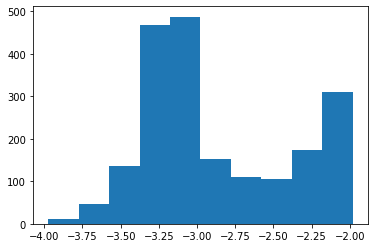

In [97]:
plt.hist(log_prob_nvp_chain(ps, cs, log_prob_n01, X));

In [98]:
from jax.experimental import optimizers
from jax import jit, grad
import numpy as onp
ps, cs = init_nvp_chain(4)

def loss(params, batch):
    return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)
    return opt_update(i, g, opt_state)

iters = int(1e4)
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)
for i in range(iters):
    opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

In [99]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

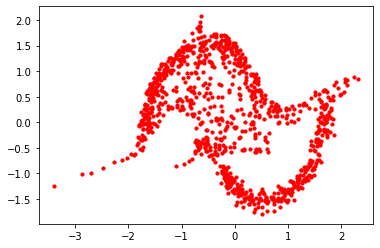

In [100]:
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')